In [35]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
from datetime import datetime
import mplcyberpunk
from copy import deepcopy as dc

%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [36]:
# #대한민국 데이터만 추출 후 일자별 확진자 수로 변환
# confirmed = pd.read_csv('time_series_covid19_confirmed_global.csv')
# korea = confirmed[confirmed['Country/Region']=='Korea, South'].iloc[:,4:].T
# korea.index = pd.to_datetime(korea.index)
# daily_cases = korea.diff().fillna(korea.iloc[0]).astype('int')
# daily_cases.shape

df = pd.read_csv('./NVDA_110721_Final_1_fdr.csv', index_col=['Date'])
df_X = dc(df[['Close']])
df_y = dc(df[['Close']])

df_X, df_y

(                 Close         MA5        MA20        MA60      RSI14  \
 Date                                                                    
 2011/07/21    3.675000    3.543000    3.782250    4.299750  40.927948   
 2011/07/22    3.750000    3.588000    3.767125    4.281833  45.013998   
 2011/07/25    3.690000    3.636000    3.754875    4.262042  42.482342   
 2011/07/26    3.600000    3.645000    3.742250    4.238708  38.944195   
 2011/07/27    3.465000    3.636000    3.721750    4.214250  34.326053   
 ...                ...         ...         ...         ...        ...   
 2021/07/14  198.414993  201.113998  196.027248  169.003166  60.429947   
 2021/07/15  189.662506  199.241000  196.605248  169.635666  49.087893   
 2021/07/16  181.610001  195.462500  196.357124  170.102416  41.390788   
 2021/07/19  187.797501  191.997000  196.427624  170.757333  48.122163   
 2021/07/20  186.119995  188.720999  196.519998  171.315124  46.560841   
 
                  std      upperb   

In [101]:
df['Close'].iloc[40]

3.865

In [37]:
def create_sequences(X, y, seq_length):
    xs = []
    ys = []
    for i in range(len(X) - seq_length):
        _X = X.iloc[i : (i+seq_length)]
        _y = y.iloc[i + seq_length]
        xs.append(_X)
        ys.append(_y)
    return np.array(xs), np.array(ys)

#지도학습용 데이터로 변환
seq_length = 40
X, y = create_sequences(df_X, df_y, seq_length)

In [38]:
X.shape, y.shape

((2476, 40, 12), (2476, 1))

In [39]:
#학습용, 검증용, 시험용으로 분리
train_size = int(X.shape[0] * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+33], y[train_size:train_size+33]
X_test, y_test = X[train_size+33:], y[train_size+33:]

X_train.shape, X_val.shape, X_test.shape

((1980, 40, 12), (33, 40, 12), (463, 40, 12))

In [ ]:
# # MinMax Scaling
# scaler_x = MinMaxScaler()
# scaler_x.fit(X_train)
# scaler_y = MinMaxScaler()
# scaler_y.fit(y_train)

# X_train = scaler_x.transform(X_train)
# y_train = scaler_y.transform(y_train)

# X_val = scaler_x.transform(X_val)
# y_val = scaler_y.transform(y_val)

# X_test = scaler_x.transform(X_test)
# y_test = scaler_y.transform(y_test)

In [40]:
MIN = X_train.min()
MAX = X_train.max()

def MinMaxScale(array, min, max):
    return (array - min) / (max - min)

#MinMax 스케일링
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

In [43]:
MAX

8330.209961

In [23]:
def make_Tensor(array):
    return torch.from_numpy(array).type('torch.FloatTensor')

X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

In [24]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

torch.Size([1980, 40, 1]) torch.Size([33, 40, 1]) torch.Size([463, 40, 1])
torch.Size([1980, 1]) torch.Size([33, 1]) torch.Size([463, 1])


In [25]:
class CovidPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred
    

In [26]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None,
    num_epochs=100, verbose=10, patience=10):

    loss_fn = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data):

            model.reset_hidden_state() # seq 별 hidden state reset 

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        
        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'''Epoch {t} train loss: {epoch_loss / len(train_data)} 
                    val loss: {val_loss / len(val_data)}''')
            
            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'''Epoch {t} train loss: {epoch_loss / len(train_data)}
                ''')
      
    return model, train_hist, val_hist

In [27]:
model = CovidPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)

model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.014275392742164321 
                    val loss: 0.028649669140577316
Epoch 10 train loss: 0.0066355931163104625 
                    val loss: 0.014198580756783485
Epoch 20 train loss: 0.00628259920931393 
                    val loss: 0.014551550149917603
Epoch 30 train loss: 0.0063755989155844985 
                    val loss: 0.015349584631621838
Epoch 40 train loss: 0.006304973834476462 
                    val loss: 0.014718733727931976
Epoch 50 train loss: 0.006190849749213837 
                    val loss: 0.014818413183093071
Epoch 60 train loss: 0.006313961231610691 
                    val loss: 0.015068640001118183
Epoch 70 train loss: 0.006036993236259811 
                    val loss: 0.01529615931212902
Epoch 80 train loss: 0.006136743586808513 
                    val loss: 0.014358947984874249
Epoch 90 train loss: 0.0061092435258247825 
                    val loss: 0.014492043294012547


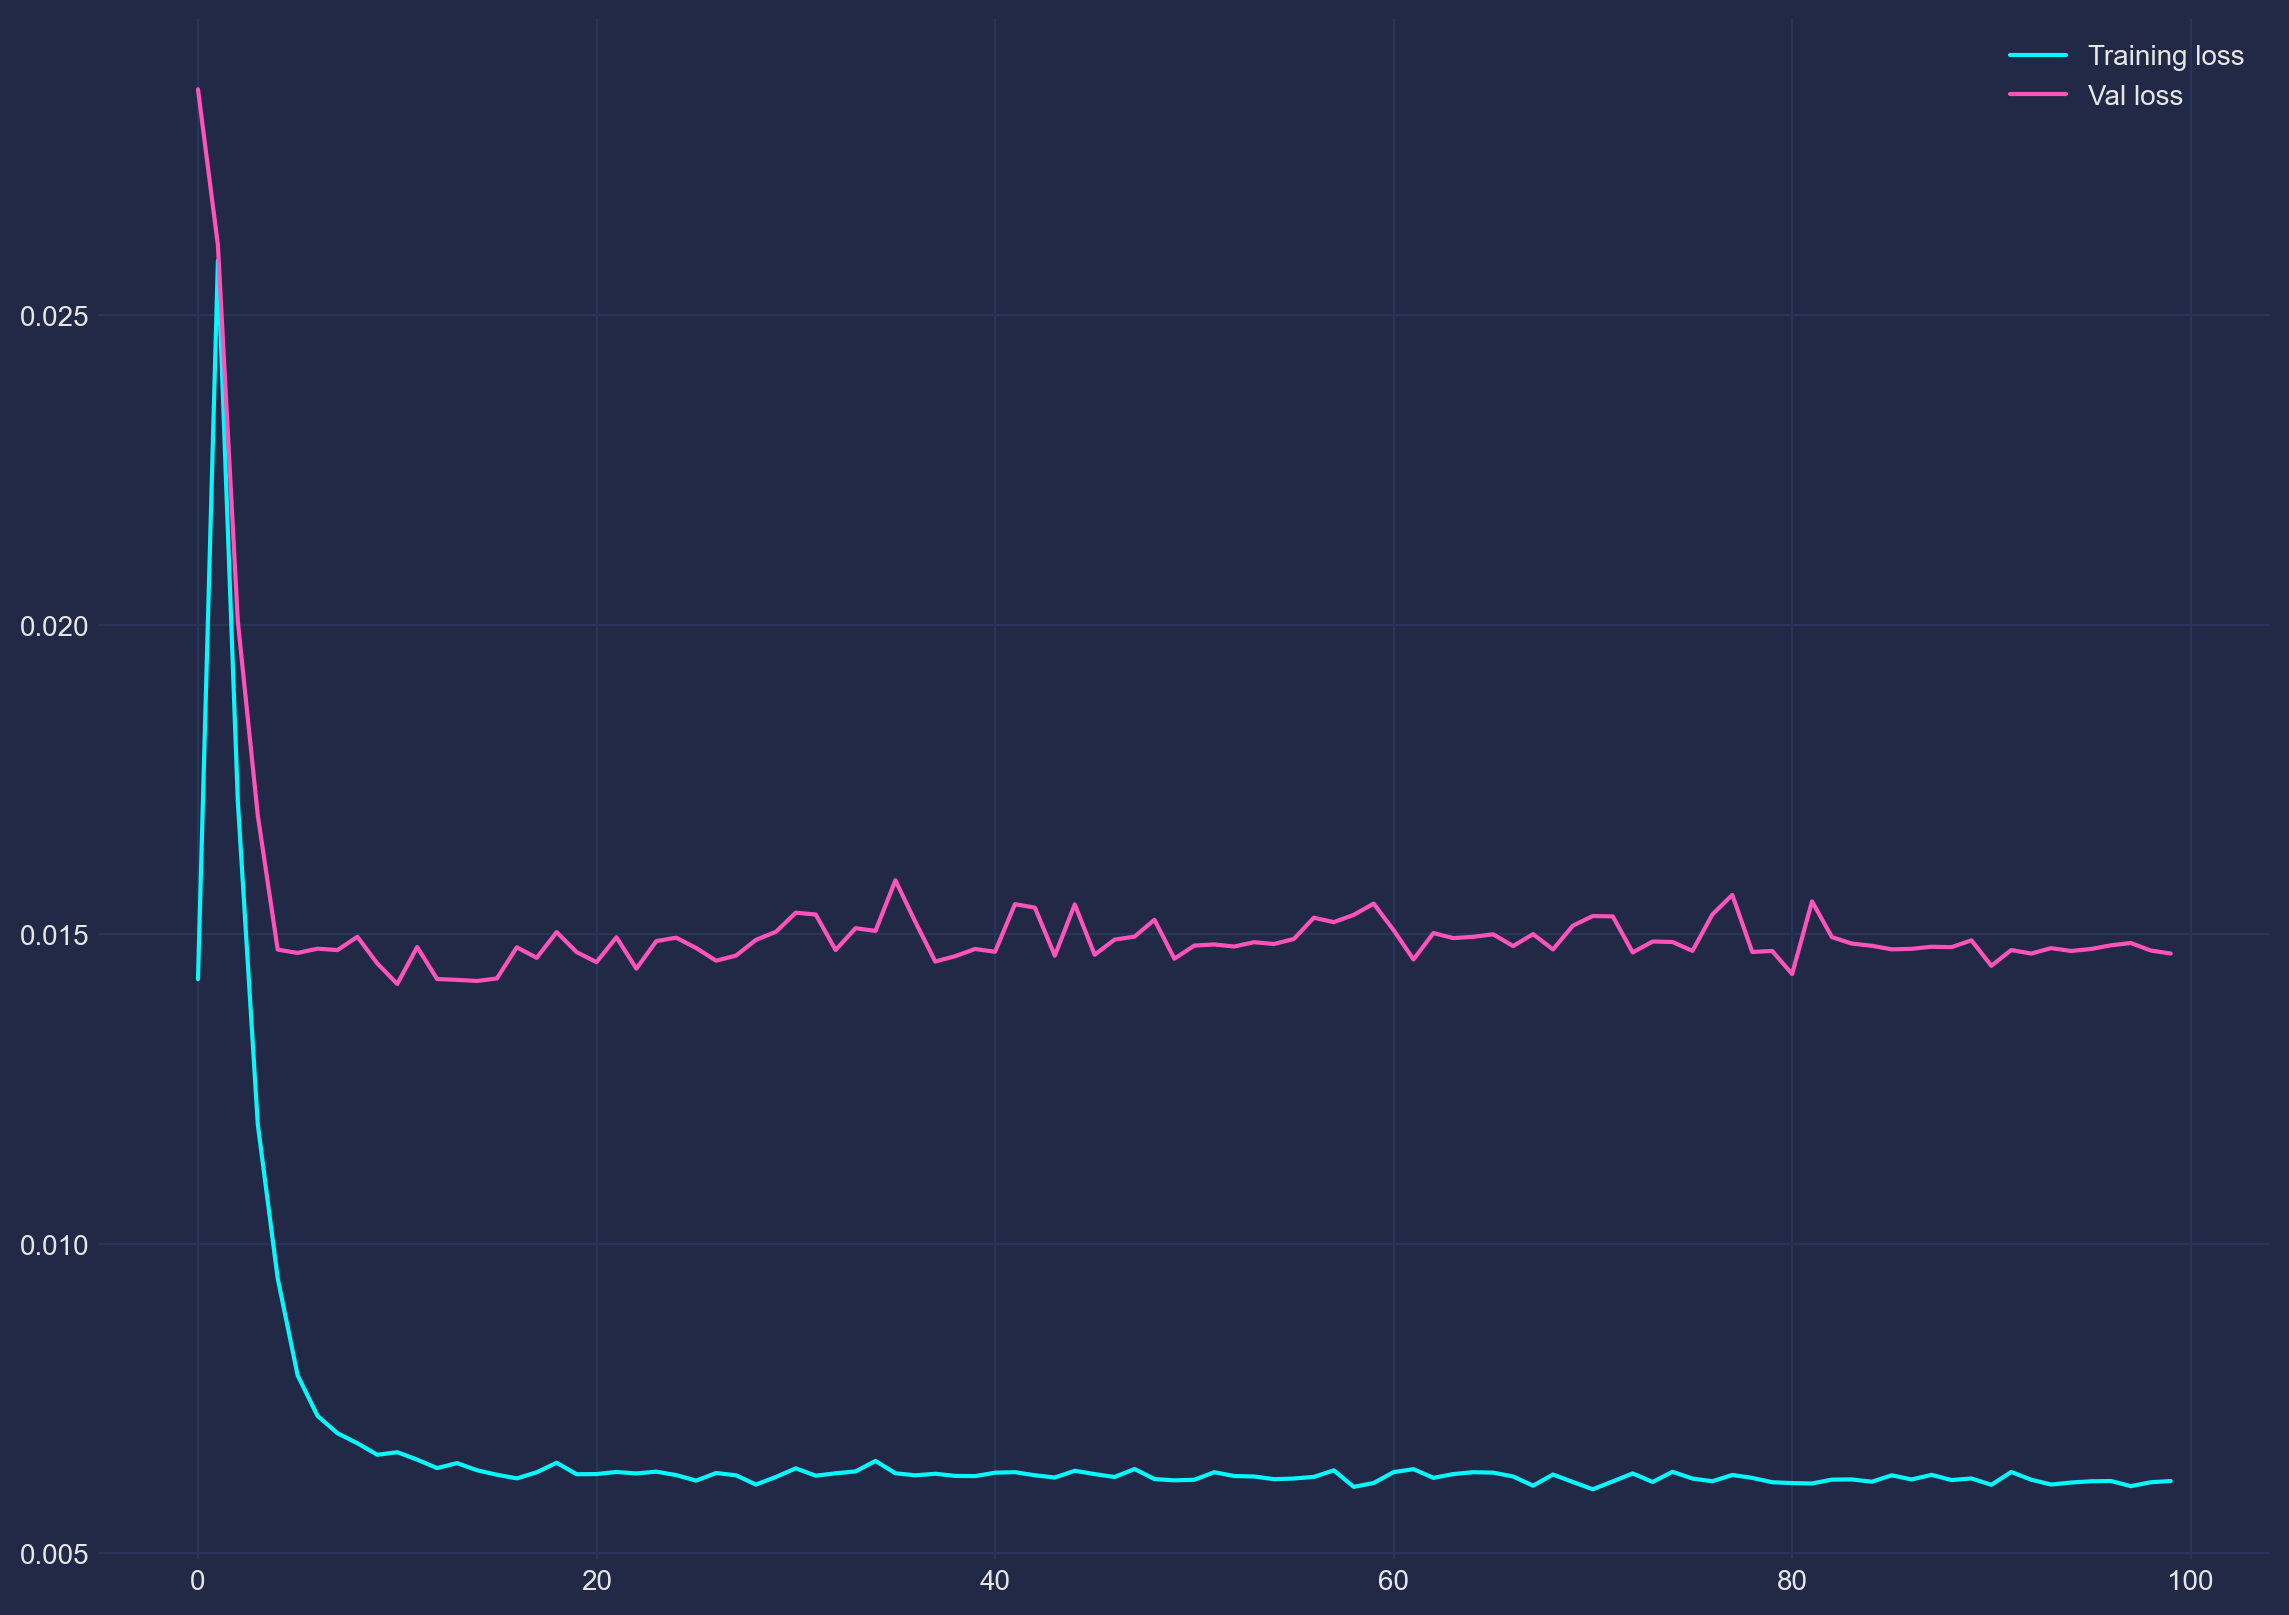

In [28]:
plt.style.use('cyberpunk')
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

In [29]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)


In [ ]:
plt.plot(df_y.index[-len(y_test), ])

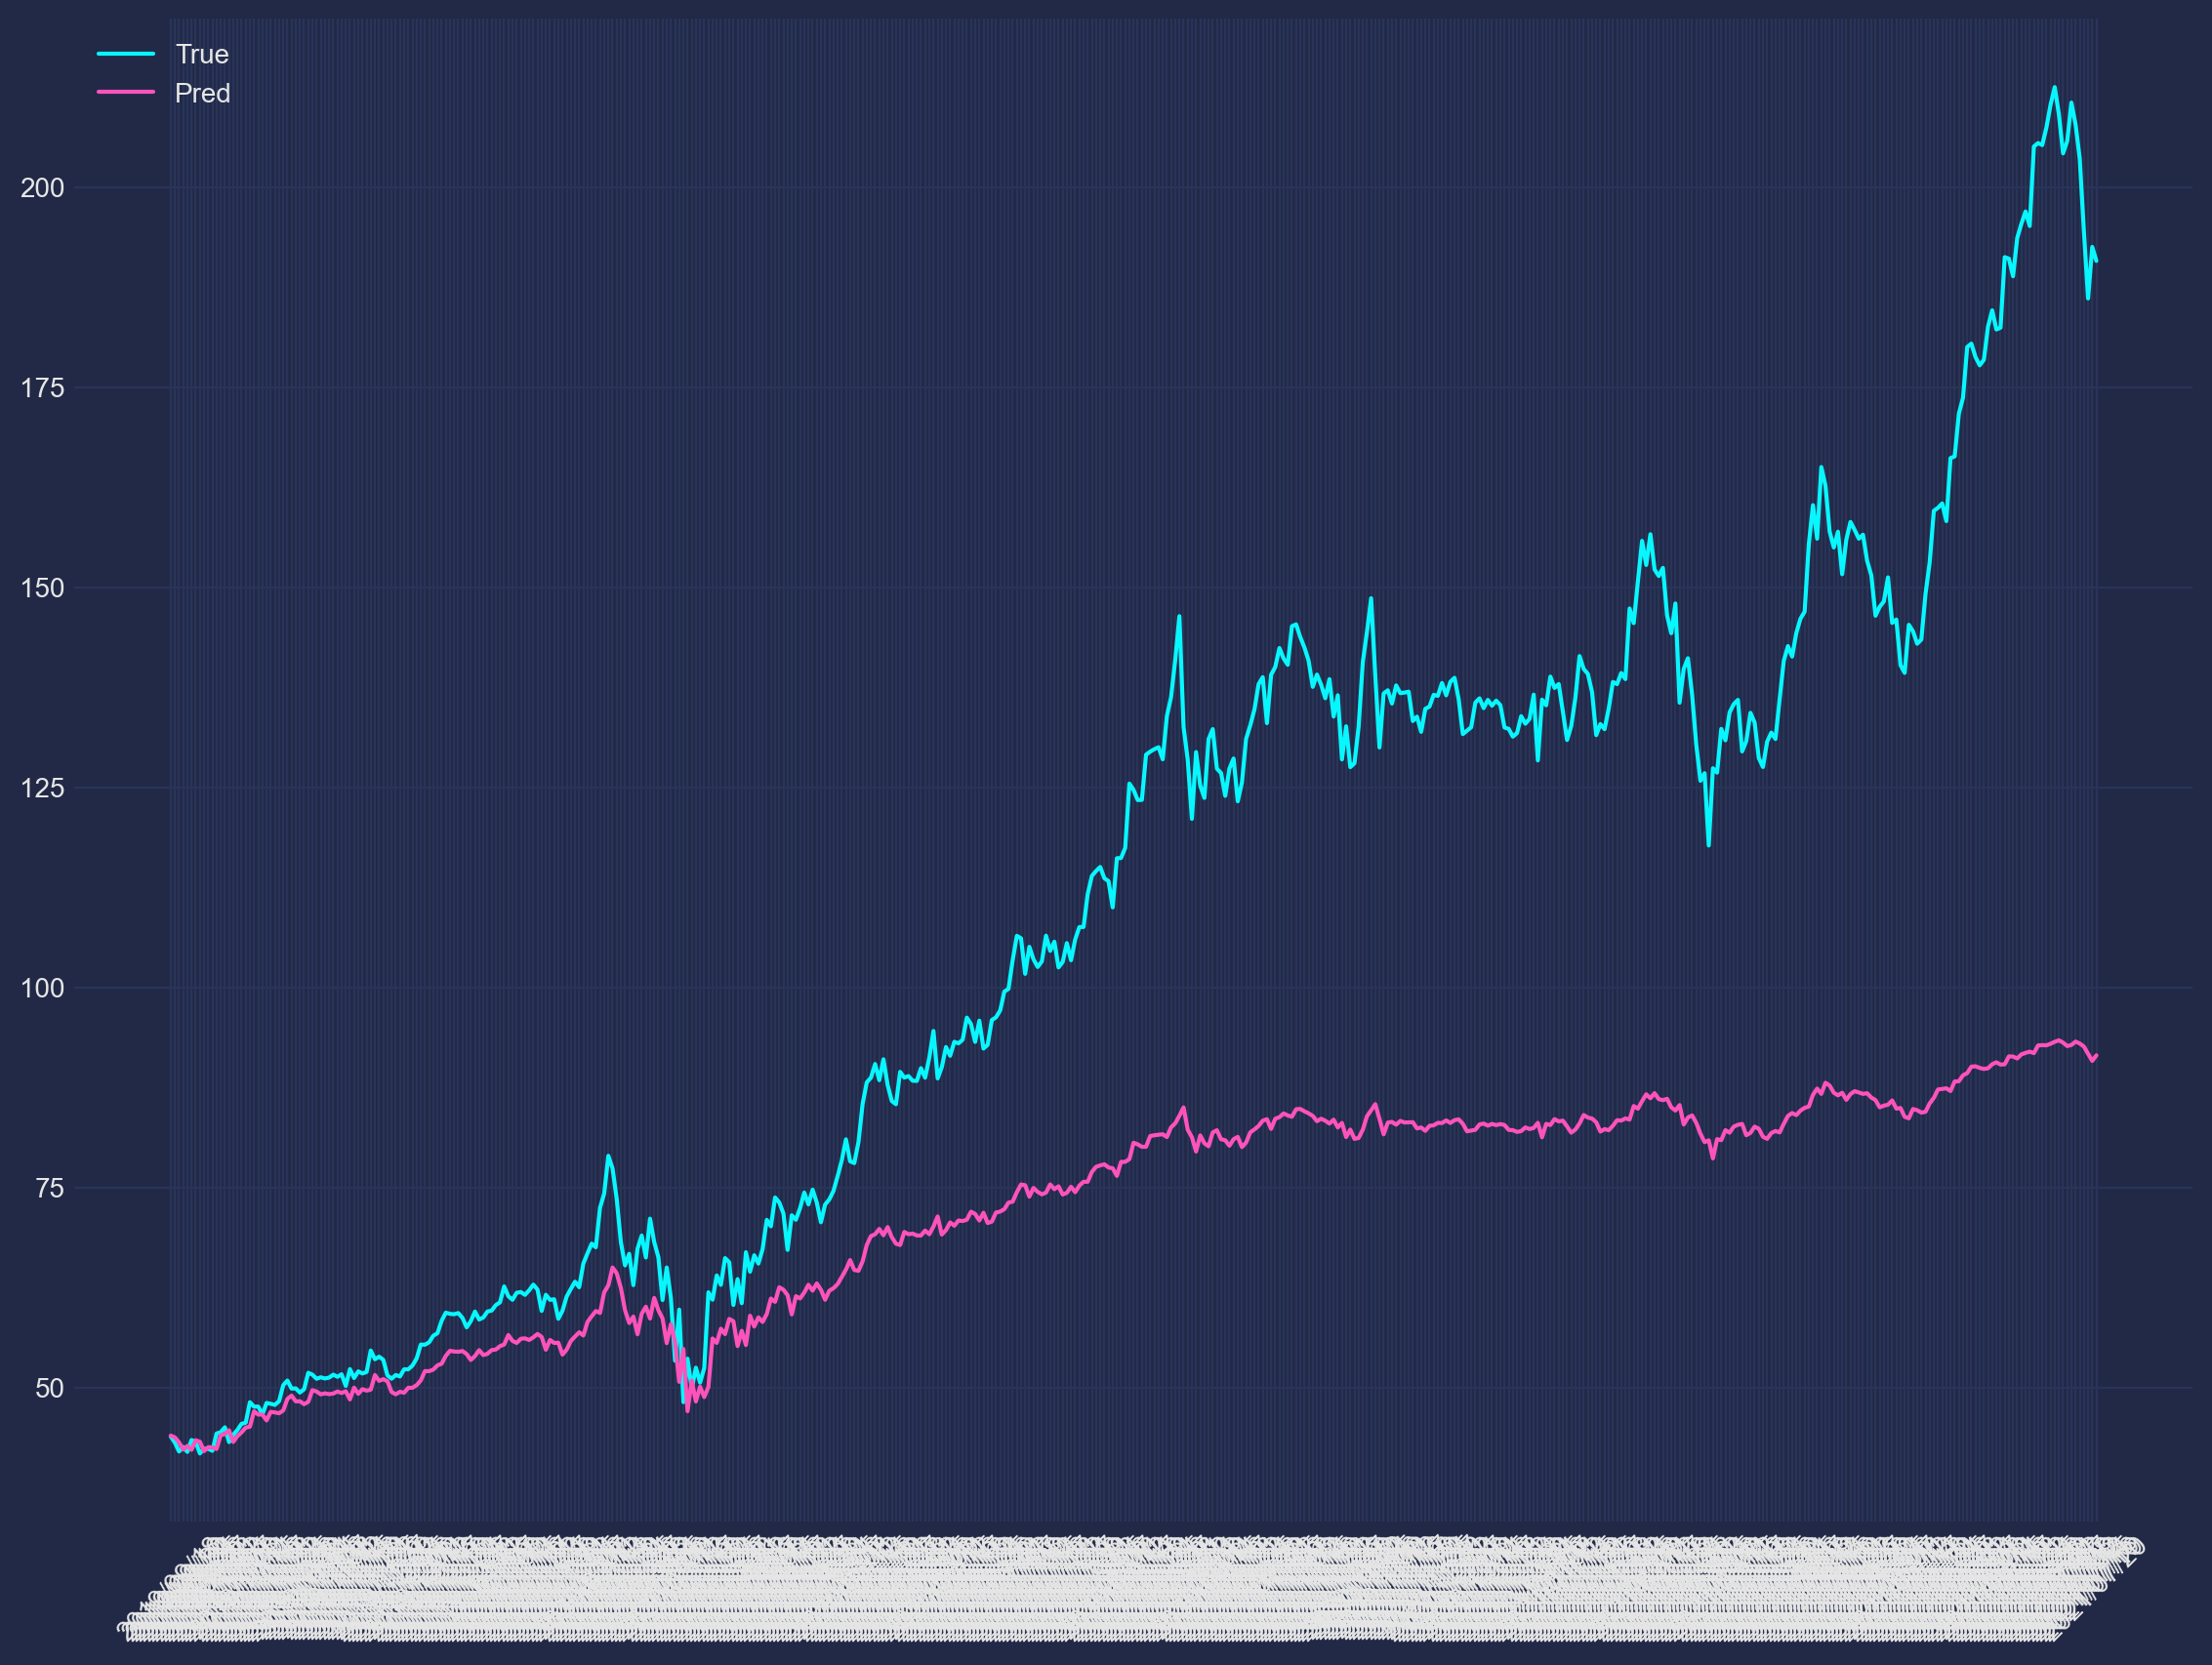

In [31]:
plt.plot(df_y.index[-len(y_test):], np.array(y_test) * MAX, label='True')
plt.plot(df_y.index[-len(preds):], np.array(preds) * MAX, label='Pred')
plt.xticks(rotation=45)
plt.legend()


In [32]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

In [34]:
MAE(np.array(y_test)*MAX, np.array(preds)*MAX)


48.14965277880013

'1.3.2'